## Time Series Analysis

Passengers - the total monthly number of passengers of the international airlines (in thousands) recorded across the span of years 1949 - 1960.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
import warnings
warnings.filterwarnings('ignore')
passengers = pd.read_csv('passengers.csv',header=0, index_col=0, parse_dates=True, sep=';')

In [2]:
passengers.head()

,n_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
#Check the regularity and frequency
passengers.index.to_series().diff().value_counts()

31 days    83
30 days    48
28 days     9
29 days     3
Name: month, dtype: int64

Text(0, 0.5, 'Passengers per month (thousands)')

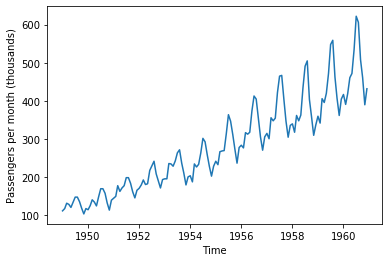

In [4]:
plt.plot(passengers.index, 
         passengers.n_passengers)
plt.xlabel('Time')
plt.ylabel('Passengers per month (thousands)')

### Simple moving average

In [5]:
# Calculate the moving average
rol_short = passengers.n_passengers.rolling(window = 7)
rol_long = passengers.n_passengers.rolling(window = 31)

# Add both to the data frame as a new columns
passengers['SMA_short'] = rol_short.mean()
passengers['SMA_long'] = rol_long.mean()

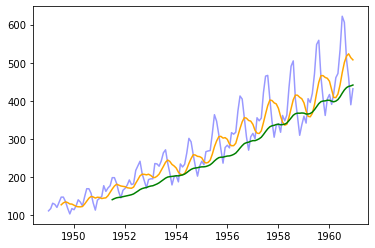

In [6]:
plt.plot(passengers.index, 
         passengers.n_passengers, 
         color = 'blue', 
         alpha = 0.4)

plt.plot(passengers.index, 
         passengers.SMA_short, 
         color = 'orange')

plt.plot(passengers.index, 
         passengers.SMA_long, 
         color = 'green')

### Exponential moving average

In [7]:
passengers['EMA_short'] = passengers.n_passengers.ewm(alpha=0.25, adjust=True).mean()
passengers['EMA_long'] = passengers.n_passengers.ewm(alpha=0.05).mean()

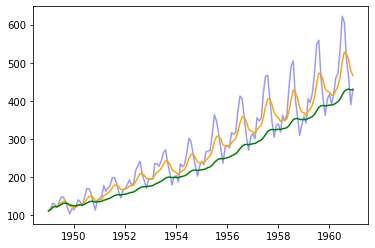

In [8]:
plt.plot(passengers.index, 
         passengers.n_passengers, 
         color = 'blue', 
         alpha = 0.4)

plt.plot(passengers.index, 
         passengers.EMA_short, 
         color = 'orange')

plt.plot(passengers.index, 
         passengers.EMA_long, 
         color = 'green')

Text(0, 0.5, 'Autocorrelation')

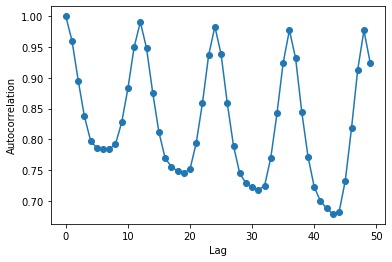

In [9]:
max_lag = 50
passengers_ac = [passengers.n_passengers.autocorr(lag=i) for i in range(max_lag)]
plt.plot(range(max_lag), passengers_ac, 'o-')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

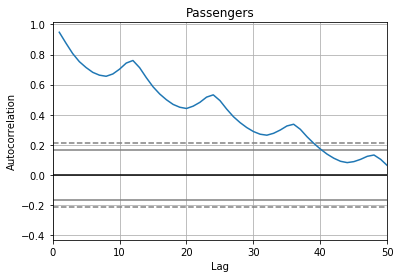

In [10]:
fig, ax = plt.subplots(1, 1)
pd.plotting.autocorrelation_plot(passengers.n_passengers, ax = ax)
ax.set_title('Passengers')

ax.set_xlim(0, max_lag)

#fig.subplots_adjust(hspace = 0.8)
plt.show()

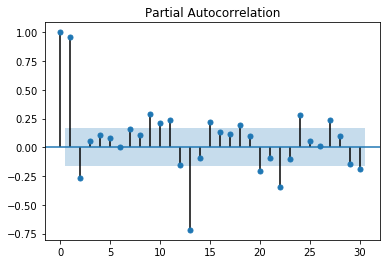

In [11]:
tsaplots.plot_pacf(passengers.n_passengers, lags=30)
plt.show()

In [12]:
# Additive model
passengers_add = seasonal_decompose(passengers.n_passengers, 
                                    model='additive')

# Multiplicative model
passengers_mlt = seasonal_decompose(passengers.n_passengers, 
                                    model='multiplicative')

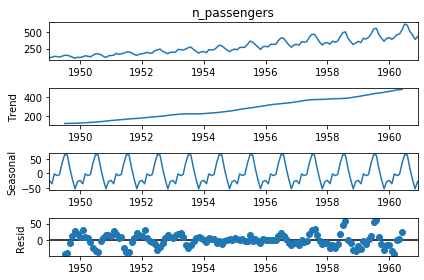

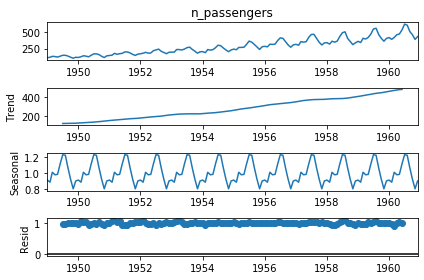

In [13]:
p1 = passengers_add.plot()
p2 = passengers_mlt.plot()
plt.show()

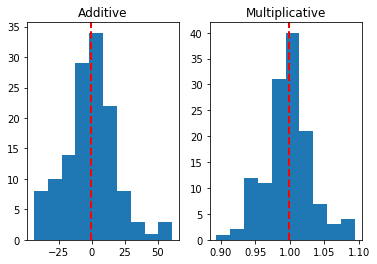

In [14]:
# Take the residuals of both models and remove NaNs
r1 = passengers_add.resid.dropna()
r2 = passengers_mlt.resid.dropna()

# Calculate means
mu1 = r1.mean()
mu2 = r2.mean()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(r1)
ax2.hist(r2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

# Add vertical lines to highlight the means
ax1.axvline(x = mu1, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

ax2.axvline(x = mu2, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

plt.show()

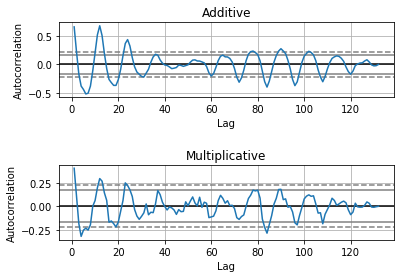

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1)

pd.plotting.autocorrelation_plot(r1, ax = ax1)
pd.plotting.autocorrelation_plot(r2, ax = ax2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

plt.subplots_adjust(hspace = 0.9)
plt.show()

In both cases we observe that the noise shows some correlation with its previous values. However, in the case of the additive model, the autocorrelation is much stronger. We can conclude that the multiplicative model is the better alternative.

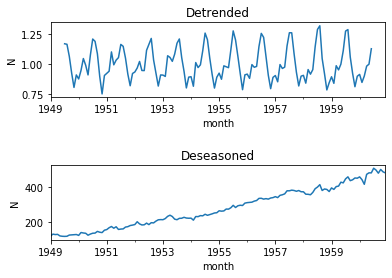

In [16]:
passengers['detrended'] = passengers.n_passengers / passengers_mlt.trend
passengers['deseasoned'] = passengers.n_passengers / passengers_mlt.seasonal
 
fix, (ax1, ax2) = plt.subplots(2, 1)
passengers['detrended'].plot(ax = ax1)
passengers['deseasoned'].plot(ax = ax2)

ax1.set_ylabel('N')
ax2.set_ylabel('N')

ax1.set_title('Detrended')
ax2.set_title('Deseasoned')

plt.subplots_adjust(hspace = 0.9)
plt.show()

In [17]:
trend_strength = 1. - np.var(passengers_mlt.resid) / np.var(passengers_mlt.resid * passengers_mlt.trend)
seasonality_strength = 1. - np.var(passengers_mlt.resid) / np.var(passengers_mlt.resid * passengers_mlt.seasonal)

In [18]:
print ('Strength of trend is: %1.3f' % trend_strength)
print ('Strength of seasonality is: %1.3f' % seasonality_strength)

Strength of trend is: 1.000
Strength of seasonality is: 0.936


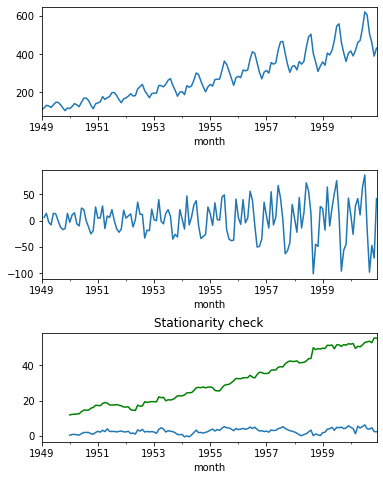

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 8))

# Plot the passengers numbers
passengers.n_passengers.plot(ax = ax1)

# Plot differentiated signal
passengers.n_passengers.diff().plot(ax = ax2)

# PLot the moving average and moving standard deviation
passengers.n_passengers.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
passengers.n_passengers.diff().rolling(12).std().plot(ax = ax3, color = 'green')

# Plot
plt.subplots_adjust(hspace = 0.5)
plt.show()

As we can see, even the differentiated signal is not fully stationary as its standard deviation is growing with time. One simple way to resolve it is to logarithmize the signal prior its differentiation:

In [20]:
passengers['n_passengers_log'] = np.log(passengers['n_passengers'])

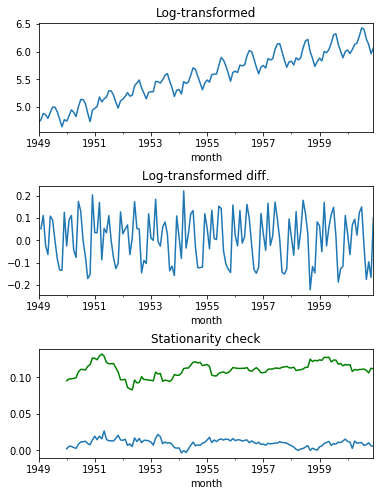

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (6, 8))
# Plot the log-transformed signal
passengers.n_passengers_log.plot(ax = ax1, title = 'Log-transformed')

# Plot differentiated log-transformed signal
passengers.n_passengers_log.diff().plot(ax = ax2, title = 'Log-transformed diff.')

# Plot the moving average and moving standard deviation
passengers.n_passengers_log.diff().rolling(12).mean().plot(ax = ax3, title = 'Stationarity check')
passengers.n_passengers_log.diff().rolling(12).std().plot(ax = ax3, color = 'green')
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [22]:
n = np.int(len(passengers) * 0.7)
train, test = passengers.iloc[:n], passengers.iloc[n:]

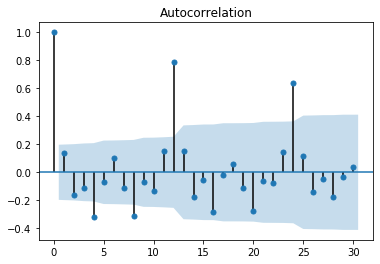

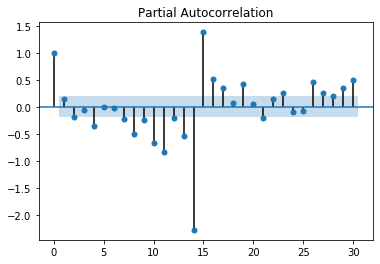

In [23]:
p1 = tsaplots.plot_acf(train.n_passengers_log.diff().dropna(), lags=30, alpha=0.05)
p2 = tsaplots.plot_pacf(train.n_passengers_log.diff().dropna(), lags=30, alpha=0.05)
plt.show()

In [24]:
arima = ARIMA(train.n_passengers_log.dropna().astype(float), order=(1,1,1))
arima_fit = arima.fit(disp=1, maxiter=100)
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.n_passengers_log   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  92.419
Method:                       css-mle   S.D. of innovations              0.094
Date:                Fri, 22 May 2020   AIC                           -176.837
Time:                        11:00:20   BIC                           -166.457
Sample:                    02-01-1949   HQIC                          -172.637
                         - 04-01-1957                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0110      0.001     11.822      0.000       0.009       0.013
ar.L1.D.n_passengers_log     0.6729      0.076      8.814      0.000       0.523       0.

In [25]:
p, err, conf = arima_fit.forecast()
print ('Predicted no. of passengers [log]: %1.2f' %  p)
print ('Standard error of the prediction: %1.2f' % err)
print ('COnfidence interval: (%1.2f, %1.2f)' % (conf[0][0], conf[0][1]))

y_hat = np.exp(p)
y = test.n_passengers[0]

Predicted no. of passengers [log]: 5.87
Standard error of the prediction: 0.09
COnfidence interval: (5.69, 6.05)


In [26]:
print ('Predicted number of pasengers: %1.2f' % y_hat)
print ('Actual number of passengers: %i' % y)
print ('Absolute error: %1.2f' % np.abs(y_hat - y))
print ('Relative error %1.2f%%' % (np.abs(y_hat - y) / y * 100))

Predicted number of pasengers: 354.46
Actual number of passengers: 355
Absolute error: 0.54
Relative error 0.15%


In [27]:
# Define the history
hist = list(train.n_passengers_log.dropna().astype(float))

# Initialize container for predictions
pred = []
for i in range(len(test)):
    # Initalize the model
    arima = ARIMA(hist, order=(6,1,0))
    #Fit the model on the available history
    arima_fit = arima.fit(disp=1, maxiter=500)
    # Take the prediction
    pred.append(arima_fit.forecast()[0][0])   
    # Expand the history
    hist.append(test.n_passengers_log[i])

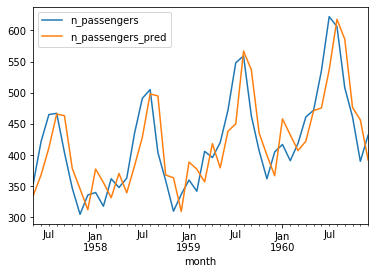

In [28]:
test['n_passengers_pred'] = np.exp(pred)
test[['n_passengers', 'n_passengers_pred']].plot()

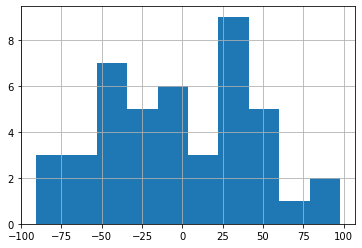

In [29]:
test['error'] = test.n_passengers - test.n_passengers_pred
test.error.hist()

In [30]:
arima = ARIMA(train.n_passengers_log.dropna().astype(float), order=(1,1,1))
arima_fit = arima.fit(disp=1, maxiter=100)

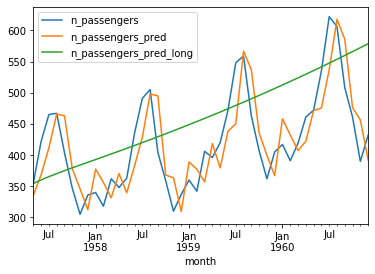

In [31]:
pred,_,_ = arima_fit.forecast(steps=len(test))
test['n_passengers_pred_long'] = np.exp(pred)
test[['n_passengers', 'n_passengers_pred', 'n_passengers_pred_long']].plot()

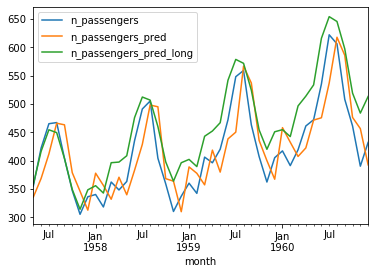

In [32]:
arima = ARIMA(train.n_passengers_log.dropna().astype(float), order=(12,1,6))
arima_fit = arima.fit(disp=1, maxiter=500)
pred,_,_ = arima_fit.forecast(steps=len(test))
test['n_passengers_pred_long'] = np.exp(pred)
test[['n_passengers', 'n_passengers_pred', 'n_passengers_pred_long']].plot()